<a href="https://colab.research.google.com/github/CalculatedContent/xgboost2ww/blob/main/notebooks/BadModelsXGBoost2WW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XGBoost2WW — Overfitting Lab (50–100 Models)

This notebook intentionally trains **overfit XGBoost models** in several different ways, then runs **WeightWatcher diagnostics** on **W7** via `xgboost2ww`.

You choose **one overfitting method per run** (set `OVERFIT_MODE` below), and run the notebook multiple times (5–6) to compare behaviors.

**What gets saved:** one Feather results file to Google Drive at the end of the run.  
The filename includes the chosen overfitting method.

**Overfitting modes:**
1. `deep_trees` — very large `max_depth`
2. `too_many_rounds` — lots of boosting rounds, weak early stopping
3. `no_regularization` — remove λ/α/γ regularization
4. `no_subsampling` — subsample=1 and colsample=1 (high tree correlation)
5. `tiny_trainset` — tiny training set with normal capacity (high variance)
6. `leakage` — OPTIONAL: synthetic label leakage feature (do NOT use in real work)



## Choose  overfitting mode and run size

Set:

- `OVERFIT_MODE` to one of the modes listed above
- `N_MODELS` to 50–100 (recommended)

We train **N_MODELS random models** (different seeds and randomized hyperparameters), but the selected `OVERFIT_MODE` pushes each model into the same failure regime.

At the end we save one Feather file to Google Drive:

`overfit_<OVERFIT_MODE>_<N_MODELS>models_<timestamp>.feather`

In [1]:
# ============================================
# Global Settings
# ============================================

import numpy as np

# Reproducibility
RNG = 0
rng = np.random.default_rng(RNG)

# Data selection
SUITE_IDS = [14, 99, 225]
TARGET_DATASETS = 10

# Number of random models per run
N_MODELS = 5

# Train/test split
TEST_SIZE = 0.20

# OOF construction (for W7)
NFOLDS = 5
T_TRAJ = 160

# Dataset caps (memory safety)
MAX_OPENML_ROWS = 60000
MAX_FEATURES_GUARD = 50_000

# Overfitting mode (choose ONE per run)
OVERFIT_MODE = "deep_trees"
# Options:
# "deep_trees"
# "too_many_rounds"
# "no_regularization"
# "no_subsampling"
# "tiny_trainset"
# "leakage"

# Only used in tiny_trainset mode
TINY_TRAIN_FRAC = 0.2

In [2]:
# --- 1) Mount Drive and set output folder ---
from google.colab import drive
import os
from datetime import datetime

drive.mount("/content/drive", force_remount=False)

GDRIVE_DIR = "/content/drive/MyDrive/xgboost2ww_runs"
os.makedirs(GDRIVE_DIR, exist_ok=True)
print("Saving results to:", GDRIVE_DIR)

# --- 2) Install dependencies ---
!pip -q install "pandas==2.2.2" xgboost weightwatcher scikit-learn openml scipy pyarrow
!pip -q install --upgrade xgboost2ww

# --- 3) Imports ---
import warnings, time, json
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import xgboost as xgb
import openml

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import torch
import weightwatcher as ww

print("Imports OK.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saving results to: /content/drive/MyDrive/xgboost2ww_runs


Imports OK.


## GPU detection (optional)

If a GPU is available, we use `gpu_hist` to speed up training.
If not, we fall back to CPU `hist`.

In [3]:
def xgb_gpu_available() -> bool:
    try:
        Xtmp = np.random.randn(256, 8).astype(np.float32)
        ytmp = (Xtmp[:, 0] > 0).astype(np.int32)
        dtmp = xgb.DMatrix(Xtmp, label=ytmp)
        params = dict(
            objective="binary:logistic",
            eval_metric="logloss",
            tree_method="gpu_hist",
            predictor="gpu_predictor",
            max_depth=2,
            learning_rate=0.2,
            seed=RNG,
        )
        _ = xgb.train(params=params, dtrain=dtmp, num_boost_round=5, verbose_eval=False)
        return True
    except Exception:
        return False

USE_GPU = xgb_gpu_available()
print("XGBoost GPU available:", USE_GPU)

XGBoost GPU available: False


## Load OpenML binary datasets (simple preprocessing)

We:
- keep only **binary** datasets
- impute missing values
- one-hot encode categorical features

This keeps transformations simple and reproducible.

In [4]:
def factorize_binary(y_raw):
    y_codes, uniques = pd.factorize(y_raw)
    if len(uniques) != 2:
        return None
    return y_codes.astype(int)

def make_preprocessor(Xdf: pd.DataFrame):
    cat_cols = Xdf.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
    num_cols = [c for c in Xdf.columns if c not in cat_cols]
    transformers = []
    if len(num_cols):
        transformers.append(("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), num_cols))
    if len(cat_cols):
        transformers.append(("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("oh", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
        ]), cat_cols))
    if not transformers:
        raise ValueError("no usable columns")
    return ColumnTransformer(transformers=transformers, remainder="drop", sparse_threshold=0.3)

def enumerate_openml_dataset_ids_from_suites(suite_ids):
    ids, seen = [], set()
    for sid in suite_ids:
        suite = openml.study.get_suite(sid)
        for did in suite.data:
            did = int(did)
            if did not in seen:
                ids.append(did)
                seen.add(did)
    return ids

def load_openml_dataset_by_id(did: int):
    ds = openml.datasets.get_dataset(did)
    target = ds.default_target_attribute
    Xdf, y_raw, _, _ = ds.get_data(dataset_format="dataframe", target=target)

    y = factorize_binary(y_raw)
    if y is None:
        return None

    # cap rows for speed
    if MAX_OPENML_ROWS is not None and len(Xdf) > MAX_OPENML_ROWS:
        take = rng.choice(len(Xdf), size=MAX_OPENML_ROWS, replace=False)
        Xdf = Xdf.iloc[take].reset_index(drop=True)
        y = y[take]

    pre = make_preprocessor(Xdf)
    X = pre.fit_transform(Xdf)
    return X, y.astype(int), ds.name, did

## Training + Diagnostics Helpers

For each model we record:

- **Train accuracy**
- **Test accuracy**
- **Test logloss**
- **WeightWatcher diagnostics on W7**

The structural diagnostics we track are:

### 1️⃣ `alpha_W7`
Heavy-tail exponent estimate from the empirical spectral density (ESD).

- `α ≈ 2` → critical / well-regularized
- `α > 2` → suboptimal
- `α >> 2` → strongly suboptimal / undertrained
- `α < 2` → overfitting / memorization regime

---

### 2️⃣ `traps_W7`
`rand_num_spikes` from WeightWatcher.

Measures excess spectral spikes beyond the power-law bulk.

- `0` → clean heavy-tailed structure
- `>0` → correlation traps / unstable structure

---

### 3️⃣ `ERG_gap_W7`
Determinant-based ERG diagnostic.

Computed directly by running:

In [5]:
from xgboost2ww import convert

def ww_diagnostics_from_layer(layer):
    """
    Run WeightWatcher with ERG diagnostics enabled.

    Returns:
        alpha_W7
        traps_W7
        ERG_gap_W7
    """
    watcher = ww.WeightWatcher(model=layer)

    # Use ERG=True (latest WeightWatcher API)
    details_df = watcher.analyze(
        randomize=True,
        ERG=True,
        plot=False
    )

    alpha = float(details_df["alpha"].iloc[0]) if "alpha" in details_df.columns else np.nan
    traps = float(details_df["rand_num_spikes"].iloc[0]) if "rand_num_spikes" in details_df.columns else np.nan
    erg_gap = float(details_df["ERG_gap"].iloc[0]) if "ERG_gap" in details_df.columns else np.nan

    return alpha, traps, erg_gap

## Generating *random* models under a chosen overfitting mode

We want to train **N_MODELS genuinely different models**, not the same model repeated.

So for each run we:
1. Sample a fresh set of XGBoost hyperparameters (`sample_base_params`)
2. Apply a targeted *overfitting stressor* (`apply_overfit_mode`) based on `OVERFIT_MODE`
3. Train the model with an appropriate training schedule (rounds + early stopping)

This gives:
- randomness across models (different hyperparams)
- controlled failure mode (same overfit mechanism across the run)

In [6]:
def sample_base_params(seed: int):
    """
    Random-but-reasonable XGBoost parameter sampler.
    Each call produces a different model (different hyperparameters).
    """
    r = np.random.default_rng(seed)

    return dict(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        seed=seed,

        # random learning dynamics
        learning_rate=float(10 ** r.uniform(-2.0, -0.4)),   # ~0.01..0.4
        max_depth=int(r.integers(2, 7)),                    # 2..6
        min_child_weight=float(10 ** r.uniform(0.0, 2.0)),  # 1..100

        # random regularization + stochasticity
        subsample=float(r.uniform(0.6, 1.0)),
        colsample_bytree=float(r.uniform(0.6, 1.0)),
        reg_lambda=float(10 ** r.uniform(0.0, 2.5)),        # 1..316
        reg_alpha=float(10 ** r.uniform(-3.0, 1.0)),        # 0.001..10
        gamma=float(r.uniform(0.0, 1.0)),
    )

def apply_overfit_mode(params: dict, mode: str, seed: int):
    """
    Modify base params to force a specific overfitting mechanism.
    This keeps models random, but pushes them into a chosen failure regime.
    """
    p = dict(params)
    r = np.random.default_rng(seed + 999)

    if mode == "deep_trees":
        p["max_depth"] = int(r.integers(10, 16))
        p["learning_rate"] = float(r.uniform(0.1, 0.3))
        p["min_child_weight"] = float(r.uniform(1.0, 10.0))

    elif mode == "too_many_rounds":
        # Overfit mainly via too many rounds and weak early stopping.
        p["learning_rate"] = float(r.uniform(0.15, 0.35))
        p["max_depth"] = int(r.integers(4, 8))

    elif mode == "no_regularization":
        p["reg_lambda"] = 0.0
        p["reg_alpha"] = 0.0
        p["gamma"] = 0.0
        p["max_depth"] = int(r.integers(5, 9))
        p["learning_rate"] = float(r.uniform(0.15, 0.35))

    elif mode == "no_subsampling":
        p["subsample"] = 1.0
        p["colsample_bytree"] = 1.0
        p["max_depth"] = int(r.integers(4, 8))
        p["learning_rate"] = float(r.uniform(0.1, 0.3))

    elif mode == "tiny_trainset":
        p["max_depth"] = int(r.integers(6, 12))
        p["learning_rate"] = float(r.uniform(0.15, 0.35))

    elif mode == "leakage":
        # leakage is injected as a feature later
        p["max_depth"] = int(r.integers(3, 6))
        p["learning_rate"] = float(r.uniform(0.05, 0.2))

    else:
        raise ValueError(f"Unknown OVERFIT_MODE: {mode}")

    # GPU if available
    if USE_GPU:
        p["tree_method"] = "gpu_hist"
        p["predictor"] = "gpu_predictor"

    return p

def training_schedule_for_mode(mode: str):
    """
    Return (num_boost_round, early_stopping_rounds) tuned to each failure mode.
    """
    if mode == "too_many_rounds":
        return 4000, 400
    return 1000, 100

## Training one model and computing W7 diagnostics

For each model we:
1. Train XGBoost on a train split and evaluate on a holdout test split
2. Compute **W7** using `xgboost2ww.convert(...)`
3. Run WeightWatcher diagnostics (alpha, traps, ERG_gap)

Important: we pass `train_params` and `num_boost_round` into `convert()` so the OOF fold-training matches the model we actually trained.

In [7]:
def train_eval_model(Xtr, ytr, Xte, yte, params, num_boost_round, early_stop):
    """
    Train XGBoost and return:
      bst, rounds_used, train_acc, test_acc, test_loss
    """
    dtr = xgb.DMatrix(Xtr, label=ytr)
    dte = xgb.DMatrix(Xte, label=yte)

    bst = xgb.train(
        params=params,
        dtrain=dtr,
        num_boost_round=num_boost_round,
        evals=[(dtr, "train"), (dte, "test")],
        early_stopping_rounds=early_stop,
        verbose_eval=False,
    )
    rounds_used = int(bst.best_iteration + 1)

    p_tr = bst.predict(dtr).astype(np.float32)
    p_te = bst.predict(dte).astype(np.float32)

    train_acc = float(accuracy_score(ytr, (p_tr >= 0.5).astype(np.int32)))
    test_acc  = float(accuracy_score(yte, (p_te >= 0.5).astype(np.int32)))
    test_loss = float(log_loss(yte, np.vstack([1 - p_te, p_te]).T, labels=[0, 1]))

    return bst, rounds_used, train_acc, test_acc, test_loss

def compute_W7_diagnostics(bst, Xtr, ytr, params, rounds_used, seed):
    """
    Compute W7 via xgboost2ww.convert and run WeightWatcher diagnostics.

    Returns:
      alpha_W7, traps_W7, ERG_gap_W7
    """
    layer_W7 = convert(
        model=bst,
        data=Xtr,
        labels=ytr,
        W="W7",
        nfolds=NFOLDS,
        t_points=T_TRAJ,
        random_state=seed,
        train_params=params,
        num_boost_round=rounds_used,
        multiclass="error",
        return_type="torch",
        verbose=False,
    )
    return ww_diagnostics_from_layer(layer_W7)

## Run the experiment (train N_MODELS, save results, plot)

This is the main loop.

For each model:
1. Load a binary dataset (same pipeline as GoodModelsXGBoost2WW.ipynb)
2. Train a randomized XGBoost model (with `OVERFIT_MODE` applied)
3. Compute W7 diagnostics (alpha, traps, ERG_gap)
4. Append one row to `rows`

At the end:
- Save one Feather file to Google Drive (filename includes `OVERFIT_MODE`)
- Plot:
  - alpha vs test accuracy
  - ERG_gap vs test accuracy
  - traps histogram

In [8]:
import gc
import matplotlib.pyplot as plt

# -----------------------------
# Choose where results go (one file per run)
# -----------------------------
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
RESULTS_FEATHER = os.path.join(GDRIVE_DIR, f"overfit_{OVERFIT_MODE}_{N_MODELS}models_{ts}.feather")
print("Will save results to:", RESULTS_FEATHER)

# -----------------------------
# Main experiment
# -----------------------------
rows = []
models_done = 0
t0 = time.time()

dataset_ids = enumerate_openml_dataset_ids_from_suites(SUITE_IDS)

for did in dataset_ids:
    if models_done >= N_MODELS:
        break

    loaded = load_openml_dataset_by_id(int(did))
    if loaded is None:
        continue

    X, y, name, did_loaded = loaded

    # Feature guard
    if int(X.shape[1]) > MAX_FEATURES_GUARD:
        continue

    # Keep sparse CSR if available (fast + memory safe)
    if hasattr(X, "tocsr"):
        X = X.tocsr()

    # Decide how many models to train on this dataset
    # (simple balancing across datasets)
    per_dataset_budget = max(1, N_MODELS // max(1, TARGET_DATASETS))

    for j in range(per_dataset_budget):
        if models_done >= N_MODELS:
            break

        seed = int(RNG + 100000 * int(did_loaded) + j)

        # -----------------------------
        # True holdout split
        # -----------------------------
        idx = np.arange(len(y))
        tr_idx, te_idx = train_test_split(
            idx, test_size=TEST_SIZE, random_state=seed, stratify=y
        )
        Xtr, Xte = X[tr_idx], X[te_idx]
        ytr, yte = y[tr_idx], y[te_idx]

        # tiny trainset mode
        if OVERFIT_MODE == "tiny_trainset":
            sub_idx, _ = train_test_split(
                np.arange(len(ytr)),
                test_size=(1.0 - TINY_TRAIN_FRAC),
                random_state=seed,
                stratify=ytr
            )
            Xtr, ytr = Xtr[sub_idx], ytr[sub_idx]

        # leakage mode (synthetic feature)
        if OVERFIT_MODE == "leakage":
            Xtr_dense = Xtr.toarray() if hasattr(Xtr, "toarray") else np.asarray(Xtr)
            Xte_dense = Xte.toarray() if hasattr(Xte, "toarray") else np.asarray(Xte)

            leak_tr = (ytr + 0.05 * rng.standard_normal(len(ytr))).astype(np.float32).reshape(-1, 1)
            leak_te = (yte + 0.05 * rng.standard_normal(len(yte))).astype(np.float32).reshape(-1, 1)

            Xtr = np.hstack([Xtr_dense.astype(np.float32), leak_tr])
            Xte = np.hstack([Xte_dense.astype(np.float32), leak_te])

        # -----------------------------
        # Randomize model hyperparams + apply overfit stressor
        # -----------------------------
        params = apply_overfit_mode(sample_base_params(seed), OVERFIT_MODE, seed)
        num_boost_round, early_stop = training_schedule_for_mode(OVERFIT_MODE)

        # -----------------------------
        # Train + eval
        # -----------------------------
        try:
            bst, rounds_used, train_acc, test_acc, test_loss = train_eval_model(
                Xtr, ytr, Xte, yte, params, num_boost_round, early_stop
            )
        except Exception as e:
            print("SKIP train:", type(e).__name__, e)
            continue

        # -----------------------------
        # W7 diagnostics (alpha, traps, ERG_gap)
        # -----------------------------
        try:
            alpha_W7, traps_W7, ERG_gap_W7 = compute_W7_diagnostics(
                bst, Xtr, ytr, params, rounds_used, seed
            )
        except Exception as e:
            print("SKIP diagnostics:", type(e).__name__, e)
            alpha_W7, traps_W7, ERG_gap_W7 = np.nan, np.nan, np.nan

        rows.append(dict(
            overfit_mode=OVERFIT_MODE,
            dataset=name,
            openml_id=int(did_loaded),
            model_index=int(models_done),
            seed=int(seed),
            n_train=int(len(ytr)),
            n_test=int(len(yte)),
            n_features=int(X.shape[1]) if hasattr(X, "shape") else None,
            rounds=int(rounds_used),
            train_acc=float(train_acc),
            test_acc=float(test_acc),
            test_loss=float(test_loss),
            alpha_W7=float(alpha_W7),
            traps_W7=float(traps_W7),
            ERG_gap_W7=float(ERG_gap_W7),
            params_json=json.dumps(params),
        ))

        models_done += 1
        if models_done % 10 == 0:
            elapsed = (time.time() - t0) / 60.0
            print(f"[{models_done}/{N_MODELS}] mode={OVERFIT_MODE} last={name} "
                  f"train/test={train_acc:.3f}/{test_acc:.3f} "
                  f"alpha={alpha_W7:.2f} traps={traps_W7:.1f} ERG_gap={ERG_gap_W7:.2f} "
                  f"elapsed={elapsed:.1f}m", flush=True)

        # cleanup
        del bst
        gc.collect()

    # cleanup dataset
    del X, y
    gc.collect()

df = pd.DataFrame(rows)
print("\nDONE. Total models:", len(df))
display(df.head(10))

# -----------------------------
# Save results (Feather only)
# -----------------------------
df.to_feather(RESULTS_FEATHER)
print("Saved:", RESULTS_FEATHER)




Will save results to: /content/drive/MyDrive/xgboost2ww_runs/overfit_deep_trees_5models_20260222_045837.feather
SKIP diagnostics: IndexError tuple index out of range

DONE. Total models: 5


,overfit_mode,dataset,openml_id,model_index,seed,n_train,n_test,n_features,rounds,train_acc,test_acc,test_loss,alpha_W7,traps_W7,ERG_gap_W7,params_json
0,deep_trees,kr-vs-kp,3,0,300000,2556,640,73,319,0.984351,0.970313,0.097243,2.960616,0.0,77.0,"{""objective"": ""binary:logistic"", ""eval_metric""..."
1,deep_trees,breast-w,15,1,1500000,559,140,9,656,0.978533,0.942857,0.151189,2.076249,1.0,34.0,"{""objective"": ""binary:logistic"", ""eval_metric""..."
2,deep_trees,mushroom,24,2,2400000,6499,1625,116,136,1.000000,1.000000,0.003571,NaN,NaN,NaN,"{""objective"": ""binary:logistic"", ""eval_metric""..."
3,deep_trees,credit-approval,29,3,2900000,552,138,46,193,0.918478,0.913043,0.262860,3.687146,0.0,76.0,"{""objective"": ""binary:logistic"", ""eval_metric""..."
4,deep_trees,credit-g,31,4,3100000,800,200,61,632,0.830000,0.765000,0.442982,2.485628,0.0,47.0,"{""objective"": ""binary:logistic"", ""eval_metric""..."


Saved: /content/drive/MyDrive/xgboost2ww_runs/overfit_deep_trees_5models_20260222_045837.feather


# PLOT RESULTS

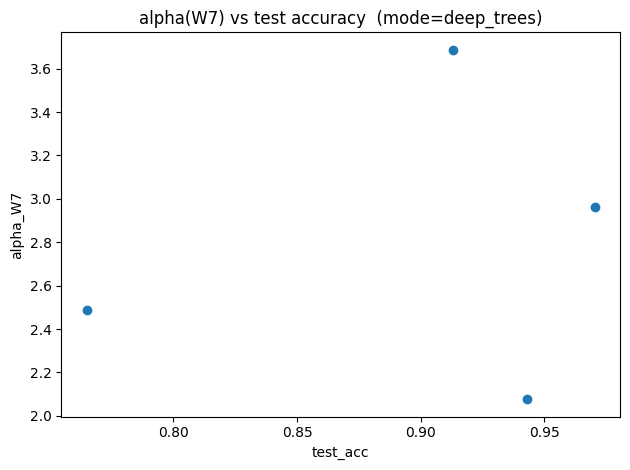

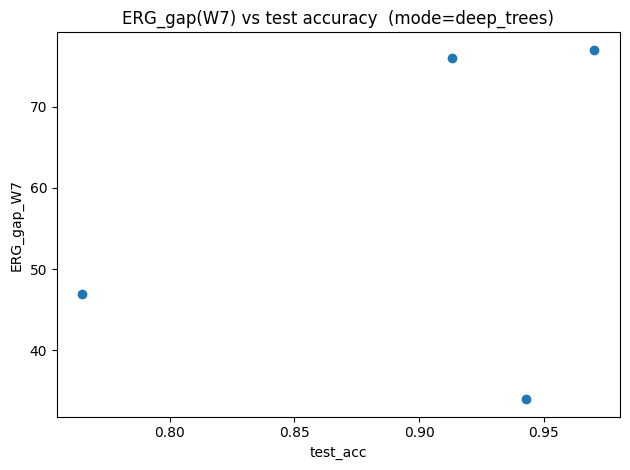

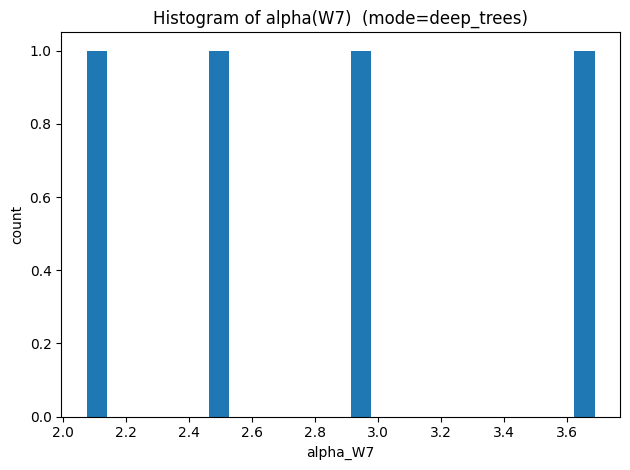

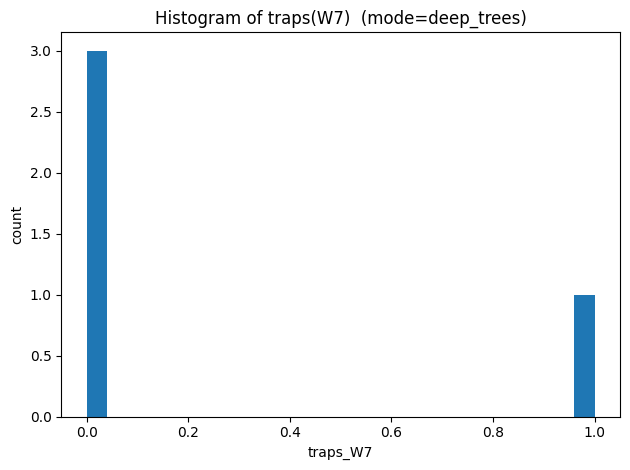

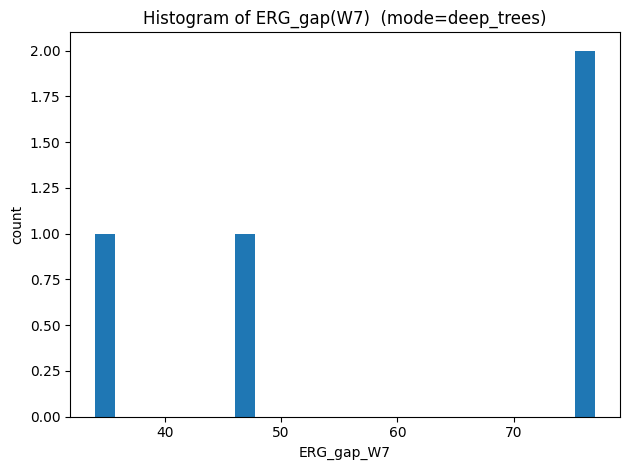

In [9]:
# -----------------------------
# Plot results
# -----------------------------
if len(df) > 0:

    # -------------------------
    # Scatter: alpha vs test accuracy
    # -------------------------
    plt.figure()
    plt.scatter(df["test_acc"].values, df["alpha_W7"].values)
    plt.xlabel("test_acc")
    plt.ylabel("alpha_W7")
    plt.title(f"alpha(W7) vs test accuracy  (mode={OVERFIT_MODE})")
    plt.tight_layout()
    plt.show()

    # -------------------------
    # Scatter: ERG_gap vs test accuracy
    # -------------------------
    plt.figure()
    plt.scatter(df["test_acc"].values, df["ERG_gap_W7"].values)
    plt.xlabel("test_acc")
    plt.ylabel("ERG_gap_W7")
    plt.title(f"ERG_gap(W7) vs test accuracy  (mode={OVERFIT_MODE})")
    plt.tight_layout()
    plt.show()

    # -------------------------
    # Histogram: alpha_W7
    # -------------------------
    plt.figure()
    plt.hist(df["alpha_W7"].dropna().values, bins=25)
    plt.xlabel("alpha_W7")
    plt.ylabel("count")
    plt.title(f"Histogram of alpha(W7)  (mode={OVERFIT_MODE})")
    plt.tight_layout()
    plt.show()

    # -------------------------
    # Histogram: traps_W7
    # -------------------------
    plt.figure()
    plt.hist(df["traps_W7"].dropna().values, bins=25)
    plt.xlabel("traps_W7")
    plt.ylabel("count")
    plt.title(f"Histogram of traps(W7)  (mode={OVERFIT_MODE})")
    plt.tight_layout()
    plt.show()

    # -------------------------
    # Histogram: ERG_gap_W7
    # -------------------------
    plt.figure()
    plt.hist(df["ERG_gap_W7"].dropna().values, bins=25)
    plt.xlabel("ERG_gap_W7")
    plt.ylabel("count")
    plt.title(f"Histogram of ERG_gap(W7)  (mode={OVERFIT_MODE})")
    plt.tight_layout()
    plt.show()

## Reload results for the selected OVERFIT_MODE

This cell loads the most recent Feather file that matches:

`overfit_{OVERFIT_MODE}_*.feather`

So you only analyze results for the overfitting method currently selected.

In [10]:
import os
import glob
import pandas as pd

# Folder where runs are saved
GDRIVE_DIR = "/content/drive/MyDrive/xgboost2ww_runs"

# Match only files for the currently selected OVERFIT_MODE
pattern = os.path.join(GDRIVE_DIR, f"overfit_{OVERFIT_MODE}_*.feather")
files = sorted(glob.glob(pattern))

if not files:
    raise FileNotFoundError(
        f"No files found for OVERFIT_MODE='{OVERFIT_MODE}' in {GDRIVE_DIR}"
    )

# Load most recent file for this mode
latest_file = files[-1]
print("Loading:", latest_file)

df_loaded = pd.read_feather(latest_file)

print("Rows:", len(df_loaded), "| Columns:", len(df_loaded.columns))
display(df_loaded.head(10))

Loading: /content/drive/MyDrive/xgboost2ww_runs/overfit_deep_trees_5models_20260222_045837.feather
Rows: 5 | Columns: 16


,overfit_mode,dataset,openml_id,model_index,seed,n_train,n_test,n_features,rounds,train_acc,test_acc,test_loss,alpha_W7,traps_W7,ERG_gap_W7,params_json
0,deep_trees,kr-vs-kp,3,0,300000,2556,640,73,319,0.984351,0.970313,0.097243,2.960616,0.0,77.0,"{""objective"": ""binary:logistic"", ""eval_metric""..."
1,deep_trees,breast-w,15,1,1500000,559,140,9,656,0.978533,0.942857,0.151189,2.076249,1.0,34.0,"{""objective"": ""binary:logistic"", ""eval_metric""..."
2,deep_trees,mushroom,24,2,2400000,6499,1625,116,136,1.000000,1.000000,0.003571,NaN,NaN,NaN,"{""objective"": ""binary:logistic"", ""eval_metric""..."
3,deep_trees,credit-approval,29,3,2900000,552,138,46,193,0.918478,0.913043,0.262860,3.687146,0.0,76.0,"{""objective"": ""binary:logistic"", ""eval_metric""..."
4,deep_trees,credit-g,31,4,3100000,800,200,61,632,0.830000,0.765000,0.442982,2.485628,0.0,47.0,"{""objective"": ""binary:logistic"", ""eval_metric""..."
